<b>Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import os
import random
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense  , Flatten
from tensorflow.keras.layers import Conv2D , MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

<b>Dataset

In [2]:
# Load the Images with Annotations
base_path   = "E:/software/Object Detection/Object Detection CNN/Dataset"
images_path = os.path.join(base_path, "images")
cvs_path    = os.path.join(base_path , "airplanes.csv")

In [3]:
# Load the CSV File and Extract the Annotation Data
annotations = open(cvs_path).read().strip().split("\n")

In [4]:
# Define the List
target = []
images = []

# Iterate the Images 
for annotation in annotations:
    # Split the Data 
    image_name , x , y , width , height = annotation.split(",")
    
    # Read the Image
    image_path = os.path.join(images_path , image_name)
    image = Image.open(image_path)
    
    # Extract the Width and Height of the Image
    w , h  = image.size
    
    # Normalize the X,y,Width,Height
    x = float(x) / w
    y = float(y) / h
    width  = float(width) / w
    height = float(height) / h
    
    # Reshape the Images
    reshape_image = image.resize((224,224))
    
    # Append the Data in the Lists
    images.append(np.array(reshape_image))
    target.append((x , y , width , height))

<b>Convert Dataset into Numpy Array

In [5]:
# Convert the Dataset into Numpy Array
Images = np.array(images , dtype = "float32") / 255.0
Target = np.array(target)

# Display the Shape of the Images and Target
print(f"Shape of the Images Matrix is : {Images.shape}")
print(f"Shape of the Target Matrix is : {Target.shape}")

Shape of the Images Matrix is : (800, 224, 224, 3)
Shape of the Target Matrix is : (800, 4)


<b>Split the Numpy Dataset into Training and Testing

In [6]:
# Split the Dataset into Training and Testing Dataset
x_train , x_val , y_train , y_val = train_test_split(Images , Target , test_size = 0.2 , random_state = 42)

# Display the Shape of the Training and Testing
print(f"Shape of the X Train is : {x_train.shape}")
print(f"Shape of the Y Train is : {y_train.shape}")
print(f"Shape of the X Valid is : {x_val.shape}")
print(f"Shape of the Y Valid is : {y_val.shape}")

Shape of the X Train is : (640, 224, 224, 3)
Shape of the Y Train is : (640, 4)
Shape of the X Valid is : (160, 224, 224, 3)
Shape of the Y Valid is : (160, 4)


<b>Load the VGG16 Pre-Trained Model

In [7]:
# Load the VGG16 Pre-Trained Model (Weights get from ImageNet Dataset)
modelVGG16 = VGG16(weights = "imagenet" , input_shape = (224,224,3) , include_top = False)

# Display the Summary of the VGG16 Model
modelVGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
# Frezee the Pre-Trained Layer
modelVGG16.trainable = False

# Flatten the Data
x = Flatten()(modelVGG16.output)

# Add the Fully Connected Layers
x = Dense(128 , activation = "relu")(x)
x = Dense(64  , activation = "relu")(x)
x = Dense(32  , activation = "relu")(x)

# Get the Output BBOX
bbox = Dense(4)(x)  # Get the Bounding Box of the Object in the Image

# Now Create the Final Model
finalModel = Model(inputs = modelVGG16.input , outputs = bbox)

# Compile the Final Model
finalModel.compile(loss = "mse" , optimizer = "adam")

# Display the Summary of the Final Model
finalModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<b>Train the Model with Training and Validating Dataset

In [9]:
# Train the Model in Train and Validation Data
history = finalModel.fit(x_train , y_train , validation_data = (x_val , y_val) , batch_size = 32 , epochs = 5 , verbose = 1)

Epoch 1/5
20/20 [==============================] - 332s 17s/step - loss: 0.4516 - val_loss: 0.0228
Epoch 2/5
20/20 [==============================] - 300s 15s/step - loss: 0.0247 - val_loss: 0.0090
Epoch 3/5
20/20 [==============================] - 320s 16s/step - loss: 0.0102 - val_loss: 0.0047
Epoch 4/5
20/20 [==============================] - 392s 20s/step - loss: 0.0049 - val_loss: 0.0044
Epoch 5/5
20/20 [==============================] - 335s 17s/step - loss: 0.0032 - val_loss: 0.0030


<b>Draw Bounding Box in Different Data

1/1 [==============================] - 0s 355ms/step


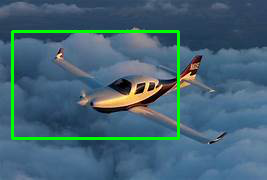

1/1 [==============================] - 0s 369ms/step


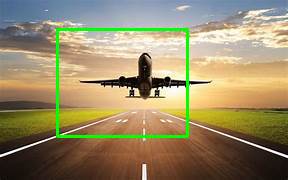

1/1 [==============================] - 0s 438ms/step


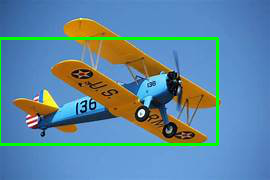

1/1 [==============================] - 0s 446ms/step


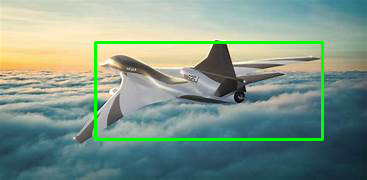

1/1 [==============================] - 0s 398ms/step


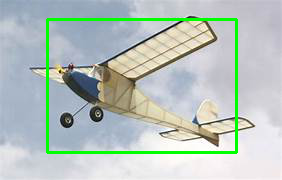

In [30]:
# Load the Test Dataset
test_dataset_path = "E:/software/Object Detection/Object Detection CNN/Testing Dataset"

for images in os.listdir(test_dataset_path):
    # Get the Path of the Image
    image_path = os.path.join(test_dataset_path , images)
    
    # Read the Image
    image = Image.open(image_path)
    w , h = image.size
    
    # Resize the Image
    resize_image = image.resize((224,224))
    
    # Convert the Resize Image into Numpy Array
    cv2_image = np.array(resize_image)
    
    # Rescale the Image
    cv2_image = cv2_image /  255.0
    
    # Predict the Image
    finalImage = np.expand_dims(cv2_image,axis=0)
    prediction = finalModel.predict(finalImage)[0]
    
    
    # Get the Bounding Box of the Image
    x = int(prediction[0] * w)
    y = int(prediction[1] * h)
    width = int(prediction[2] * w)
    height = int(prediction[3] * h)
    
    # Draw the Rectangle in the Image
    cv2_image_2 = np.array(image)
    cv2.rectangle(cv2_image_2 , (x,y) , (width , height) , (0,255,0) , 2)
    
    # Display the Images
    display(Image.fromarray(cv2_image_2))